In [1]:
! mkdir -p /root/.pip

In [2]:
%%writefile /root/.pip/pip.conf
[global]
index-url=http://ftp.daumkakao.com/pypi/simple
trusted-host=ftp.daumkakao.com

Overwriting /root/.pip/pip.conf


In [226]:
import time
import datetime
import os
import ast
import sys
import pytz
import random
import shutil
# import splitfolders
import copy
from glob import glob
from tqdm import tqdm
from pprint import pprint

import warnings
import requests

import gc
import math
import numpy as np
import pandas as pd

import cv2
from PIL import Image
# import pydicom as pdm
import pickle
import yaml
import h5py
import json
import matplotlib.pyplot as plt
# import seaborn as sns

import albumentations as albu
import torch
# import torchtuples as tt
from sklearn import metrics

import torchvision
import timm
# import pretrainedmodels

In [7]:
!pip install timm

Looking in indexes: http://ftp.daumkakao.com/pypi/simple
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [227]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else: DEVICE = torch.device('cpu')
    
print('Using PyTorchversion:', torch.__version__, 'Device:', DEVICE)

Using PyTorchversion: 1.10.0+cu113 Device: cuda


In [228]:
!ls /ainode/dataset/train/flow/

A2020-EM-01-0001_video_01  A2020-EM-01-0086_video_01  A2021-EM-01-0052_video_01
A2020-EM-01-0002_video_01  A2020-EM-01-0087_video_01  A2021-EM-01-0055_video_01
A2020-EM-01-0003_video_01  A2020-EM-01-0088_video_01  A2021-EM-01-0056_video_01
A2020-EM-01-0004_video_01  A2020-EM-01-0097_video_01  A2021-EM-01-0061_video_01
A2020-EM-01-0008_video_01  A2020-EM-01-0098_video_01  A2021-EM-01-0063_video_01
A2020-EM-01-0009_video_01  A2020-EM-01-0100_video_01  A2021-EM-01-0064_video_01
A2020-EM-01-0014_video_01  A2020-EM-01-0102_video_01  A2021-EM-01-0071_video_01
A2020-EM-01-0016_video_01  A2020-EM-01-0103_video_01  A2021-EM-01-0072_video_01
A2020-EM-01-0017_video_01  A2020-EM-01-0104_video_01  A2021-EM-01-0074_video_01
A2020-EM-01-0018_video_01  A2020-EM-01-0105_video_01  A2021-EM-01-0076_video_01
A2020-EM-01-0019_video_01  A2020-EM-01-0106_video_01  A2021-EM-01-0077_video_01
A2020-EM-01-0022_video_01  A2020-EM-01-0107_video_01  A2021-EM-01-0079_video_01
A2020-EM-01-0023_video_01  A2020-EM-01-0

In [229]:
DATA_DIR = '/ainode/dataset/train/'
case_lst = [path.split('/')[-1].split('_')[0] for path in glob(DATA_DIR+'flow/*')]
case_lst.sort()

In [230]:
case_dir = case_lst[0]

In [231]:
RGB_DIR = f'./DATA/rgb/{case_dir}_video_01'
FLOWX_DIR = f'./DATA/flowx/{case_dir}_video_01'
FLOWY_DIR = f'./DATA/flowy/{case_dir}_video_01'

rgb_lst = glob(RGB_DIR+'/*.jpg')
flowx_lst = glob(FLOWX_DIR+'/*.jpg')
flowy_lst = glob(FLOWY_DIR+'/*.jpg')

rgb_lst.sort()
flowx_lst.sort()
flowy_lst.sort()

In [232]:
p_annot_df = pd.read_csv(f'./DATA/annot.csv')
p_annot_df['ID'] = list(range(len(p_annot_df)))
p_annot_df.head()

,Event_Number,Event_Label,Start_Time,End_Time,Start_Epoch,End_Epoch,Duration(second),FPS,Frames,Case,ID
0,0,Wake,2020/05/02 22:20:30.000,2020/05/02 22:21:00.000,1,2,30.0,5.0,"[0, 150]",A2020-EM-01-0001,0
1,4,Wake,2020/05/02 22:21:00.000,2020/05/02 22:21:30.000,2,3,30.0,5.0,"[150, 300]",A2020-EM-01-0001,1
2,5,Wake,2020/05/02 22:21:30.000,2020/05/02 22:22:00.000,3,4,30.0,5.0,"[300, 450]",A2020-EM-01-0001,2
3,7,Wake,2020/05/02 22:22:00.000,2020/05/02 22:22:30.000,4,5,30.0,5.0,"[450, 600]",A2020-EM-01-0001,3
4,8,Wake,2020/05/02 22:22:30.000,2020/05/02 22:23:00.000,5,6,30.0,5.0,"[600, 750]",A2020-EM-01-0001,4


In [233]:
caselst = list(dict.fromkeys(p_annot_df['Case'].tolist()).keys())
caselst[10]

'A2020-EM-01-0019'

In [486]:
len(p_annot_df_copy)

132783

In [489]:
31660*(32888/132783)

7841.621894369008

In [234]:
p_annot_df['Event_Label'].value_counts()

Light Sleep    69757
Wake           31660
Deep Sleep     31366
Name: Event_Label, dtype: int64

In [235]:
fps = p_annot_df['FPS'][0]
print(f"Frame per second: {fps}")

def frame2epoch(frameidx): # image frame number (type 'int') to corresponding start epoch (type 'int')
    return int(frameidx//(30*fps)+1)

def epoch2frame(startepoch): # start epoch (type 'int') to corresponding image frame numbers (type 'list')
    startframe = (startepoch-1)*fps*30
    return np.arange(startframe,startframe+fps*30,1).astype('int').tolist()

Frame per second: 5.0


In [236]:
# # !rm -rf ./PDATA/case1/rgb/
# # !rm -rf ./PDATA/case1/flowx/
# # !rm -rf ./PDATA/case1/flowy/

# os.makedirs(f'./PDATA/rgb/{case_dir}/') #, exist_ok=True)
# os.makedirs(f'./PDATA/flowx/{case_dir}/') #, exist_ok=True)
# os.makedirs(f'./PDATA/flowy/{case_dir}/') #, exist_ok=True)

# # video_number = RGB_DIR.split('/')[-1]

# for idx, img in enumerate(rgb_lst):
#     epoch = frame2epoch(idx)
#     if idx % (fps*30) == 0:
#         new_dir = f'./PDATA/rgb/{case_dir}/epoch{epoch}'
#         os.makedirs(new_dir, exist_ok=True)
#     shutil.copy(img, new_dir)
    
# for idx, img in enumerate(flowx_lst):
#     epoch = frame2epoch(idx)
#     if idx % (fps*30) == 0:
#         new_dir = f'./PDATA/flowx/{case_dir}/epoch{epoch}'
#         os.makedirs(new_dir, exist_ok=True)
#     shutil.copy(img, new_dir)

# for idx, img in enumerate(flowy_lst):
#     epoch = frame2epoch(idx)
#     if idx % (fps*30) == 0:
#         new_dir = f'./PDATA/flowy/{case_dir}/epoch{epoch}'
#         os.makedirs(new_dir, exist_ok=True)
#     shutil.copy(img, new_dir)

## Train Val Test Split

In [237]:
len(p_annot_df)

132783

In [238]:
# p_annot_df_copy = p_annot_df

In [259]:
p_annot_df = p_annot_df_copy

In [260]:
n = int(len(p_annot_df)/3)
# m = int(len(p_annot_df))
# Do this first if you haven't already.
# df.compliance = df.compliance.map(pd.eval)
p_annot_df = p_annot_df.drop(p_annot_df[p_annot_df.Event_Label == "Light Sleep"].sample(n=n).index)
# p_annot_df = p_annot_df.drop(p_annot_df[p_annot_df.Event_Label == "Wake"].sample(n=m).index)

In [484]:
len(p_annot_df)

132783

In [485]:
31366*(32888/132783)

7768.8032956026

In [261]:
np.unique(np.array(p_annot_df.Event_Label), return_counts=True)

(array(['Deep Sleep', 'Light Sleep', 'Wake'], dtype=object),
 array([31366, 25496, 31660]))

In [262]:
DATA_NUM = len(glob('./max_images/*.npy'))
DATA_NUM

13977

In [263]:
# y = p_annot_df.Event_Label[:3000]
# X = p_annot_df[['ID','Start_Epoch','Case', 'FPS', 'Frames']][:3000]

In [264]:
p_annot_df=p_annot_df.sort_values(by=['Case', 'Start_Epoch'])

In [289]:
y = p_annot_df.Event_Label[:9000]
X = p_annot_df[['ID','Start_Epoch','Case', 'FPS', 'Frames']][:9000]

In [290]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.1, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,test_size=0.1, stratify = y_train)
len(X_train),len(X_val),len(X_test)

(7290, 810, 900)

In [291]:
np.unique(y_train, return_counts=True),\
np.unique(y_val, return_counts=True),\
np.unique(y_test, return_counts=True)

((array(['Deep Sleep', 'Light Sleep', 'Wake'], dtype=object),
  array([2328, 2141, 2821])),
 (array(['Deep Sleep', 'Light Sleep', 'Wake'], dtype=object),
  array([259, 238, 313])),
 (array(['Deep Sleep', 'Light Sleep', 'Wake'], dtype=object),
  array([288, 264, 348])))

In [292]:
y_train.tolist()[:10]

['Light Sleep',
 'Wake',
 'Light Sleep',
 'Light Sleep',
 'Light Sleep',
 'Deep Sleep',
 'Light Sleep',
 'Light Sleep',
 'Wake',
 'Wake']

## DataLoader

In [293]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import sklearn

In [294]:
import torchvision.transforms as transforms

In [295]:
class Dataset(BaseDataset):
    
    def __init__(
            self,  
            X,
            y,
            augmentation=None, 
            preprocessing=None,
    ):

        self.epochs = X['Start_Epoch'].tolist()
        self.cases = X['Case'].tolist()
        self.fps = X['FPS'].tolist()
        self.frames = X['Frames'].tolist()
        self.imgpaths = [f'./max_images/{self.cases[idx]}_{self.epochs[idx]}.npy' for idx in range(len(self.epochs))]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
        
        le = sklearn.preprocessing.LabelEncoder()
        self.levels = le.fit_transform(y.tolist())
    
    def __getitem__(self, i):
        
        # read data
        imgs_path = self.imgpaths[i]
        with open(imgs_path, 'rb') as f:
            image = np.load(f)
        image = np.transpose(image, (2, 1, 0))
        image = torch.Tensor(image)
        level = torch.as_tensor(self.levels[i])

        return image, level #, label
        
    def __len__(self):
        return len(self.cases)

tensor(0)


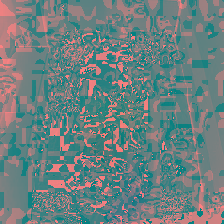

In [296]:
dataset = Dataset(X_train, y_train)
image, level = dataset[15]

# dataset.cases, dataset.epochs
# np.unique(np.array(images[6]))
# Image.fromarray(np.array(image).astype('uint8'))
print(level)
Image.fromarray(np.transpose(np.array(image).astype('uint8'), (2,1,0)))

In [297]:
BATCH_SIZE = 16

In [298]:
imagetype = 'flowx' # 'rgb', 'flowx','flowy'
labels = ['Wake', 'Light Sleep','Deep Sleep']
train_dataset = Dataset(X_train, y_train, imagetype, labels)
val_dataset = Dataset(X_val, y_val, imagetype, labels)
test_dataset = Dataset(X_test, y_test, imagetype, labels)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset)

In [299]:
print(len(train_loader))

Xtrain, ytrain = next(iter(train_loader))
print('Xtrain:', Xtrain.size(), 'type:', Xtrain.type())
print('ytrain:', ytrain.size(), 'type:', ytrain.type())

print()
print(len(val_loader))

Xval, yval = next(iter(val_loader))
print('Xval:', Xval.size(), 'type:', Xval.type())
print('yval:', yval.size(), 'type:', yval.type())

print()
print(len(test_loader))

Xtest, ytest = next(iter(val_loader))
print('Xtest:', Xtest.size(), 'type:', Xtest.type())
print('ytest:', ytest.size(), 'type:', ytest.type())

456
Xtrain: torch.Size([16, 3, 224, 224]) type: torch.FloatTensor
ytrain: torch.Size([16]) type: torch.LongTensor

51
Xval: torch.Size([16, 3, 224, 224]) type: torch.FloatTensor
yval: torch.Size([16]) type: torch.LongTensor

900
Xtest: torch.Size([16, 3, 224, 224]) type: torch.FloatTensor
ytest: torch.Size([16]) type: torch.LongTensor


In [300]:
ytrain

tensor([0, 2, 1, 2, 1, 1, 1, 2, 2, 0, 1, 1, 0, 1, 1, 2])

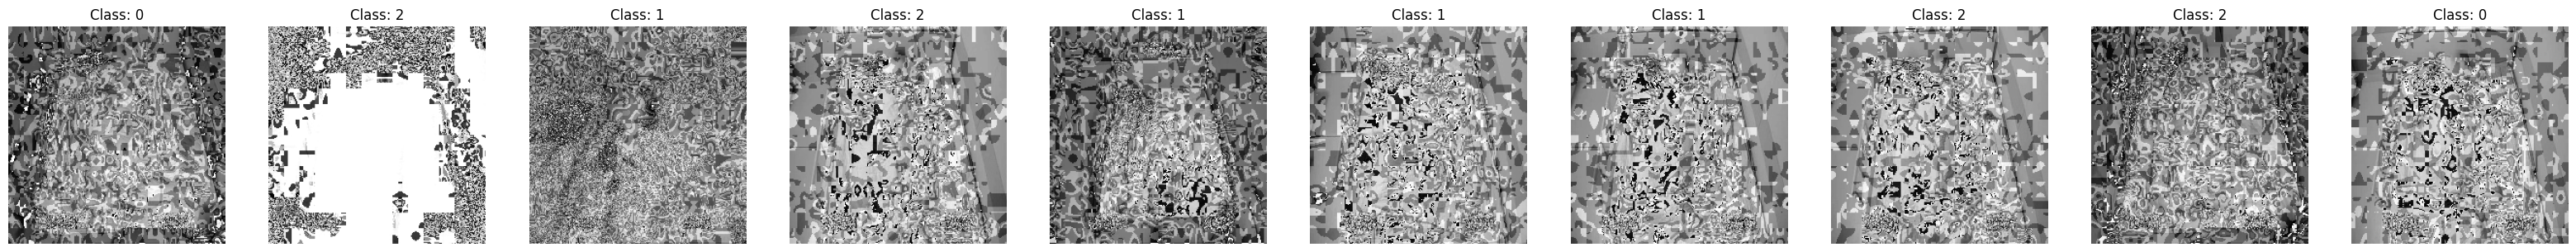

In [301]:
pltsize = 4                         

plt.figure(figsize=(10 * pltsize, pltsize))
for i in range(len(Xtrain[:10])):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    img = np.transpose(Xtrain.numpy()[i], (2,1,0))[:,:,0]
    plt.imshow(img,cmap="gray_r")
#     plt.title('Class: ' + str(y_train[i].item()))
    plt.title('Class: ' + str(ytrain[i])[-2])
plt.show()

## Train Model

In [302]:
CLASSES = 3

In [303]:
densenet = torchvision.models.densenet121(pretrained=True)

In [304]:
import torch.nn as nn  

In [305]:
# classifier layer output shape --> number of classes

num_ftrs = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_ftrs,CLASSES)
densenet.classifier = nn.Sequential(densenet.classifier, nn.Softmax(),)

densenet.classifier

Sequential(
  (0): Linear(in_features=1024, out_features=3, bias=True)
  (1): Softmax(dim=None)
)

In [306]:
LR = 0.00005
EPOCHS = 100
TRAIN_PATIENCE = 10

In [307]:
model = densenet.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                lr_lambda=lambda epoch: 0.95 ** epoch,
                                last_epoch=-1,
                                verbose=False)

In [308]:
model

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [309]:
# https://www.kaggle.com/xinruizhuang/skin-lesion-classification-acc-90-pytorch
# this function is used during training process, to calculation the loss and accuracy

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [310]:
image, label = next(iter(train_loader))
image.shape, label.shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

In [311]:
def train(model, train_loader, optimizer, log_interval):
    model.train()                                                 # assign train mode to the model
    
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        optimizer.zero_grad()                                     # 과거에 이용한 Mini-Batch내에 있는 이미지 데이터와 레이블 데이터를 바탕으로 계산된 Loss의 Gradient값이 optimizer에 할당되어 있으므로 optimizer의 Gradient 초기화
        output = model(image)
        loss = criterion(output, label)
        loss.backward()                                           # Back propagation으로 계산된 Gradient 값을 각 parameter에 할당
        optimizer.step()                                          # parameter update
        scheduler.step()
        prediction = output.max(1, keepdim = True)[1]             # predicted labels in tensor
        
        train_acc.update(prediction.eq(label.view_as(prediction)).sum().item()/BATCH_SIZE)
        train_loss.update(loss.item())
        
        if batch_idx % log_interval == 0:                         # print log
            print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(Epoch, batch_idx * len(image), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
    
    total_loss_train.append(train_loss.avg)
    total_acc_train.append(train_acc.avg)

In [312]:
def evaluate(model, test_loader):
    model.eval()
    
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    
    with torch.no_grad():                                                     # 모델을 평가하는 단계에서는 Gradient를 통해 parameter값이 update되는 현상을 방지하기 위해 'torch.no_grad()' 메서드를 이용해 Gradient의 흐름을 억제
        for image, label in val_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            loss = criterion(output, label)
            prediction = output.max(1, keepdim = True)[1]                     # output값 (prediction probability)가 가장 높은 index(class)로 예측
    
            val_acc.update(prediction.eq(label.view_as(prediction)).sum().item()/BATCH_SIZE)
            val_loss.update(loss.item())
    
    total_acc_val.append(val_acc.avg)
    total_loss_val.append(val_loss.avg)
    
    return val_loss.avg, val_acc.avg   

In [313]:
best_val_acc = 0
best_val_loss = 100
epoch = 0
total_loss_train, total_acc_train = [],[]
total_loss_val, total_acc_val = [],[]

for Epoch in range(1, EPOCHS+1):
    train(model, train_loader, optimizer, log_interval = 20)
    val_loss, val_acc = evaluate(model, test_loader)
    print("\n[EPOCH: {}], \tVal Loss: {:.4f}, \tVal Accuracy: {:.2f} %\n".format(Epoch, val_loss, val_acc))
    
    # monitoring test accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        epoch = Epoch
        print('*****************************************************')
        print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (Epoch, val_loss, val_acc))
        print('*****************************************************')
    elif Epoch > epoch + TRAIN_PATIENCE:
        break
        
#     # monitoring test loss
#     if val_loss < best_val_loss:
#         best_val_loss = val_loss
#         epoch = Epoch
#         print('*****************************************************')
#         print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (Epoch, val_loss, val_acc))
#         print('*****************************************************')
#     elif Epoch > epoch + TRAIN_PATIENCE:
#         break

/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Train Epoch: 1 [0/7290(0%)]	Train Loss: 1.093033
Train Epoch: 1 [320/7290(4%)]	Train Loss: 1.023862
Train Epoch: 1 [640/7290(9%)]	Train Loss: 0.939396
Train Epoch: 1 [960/7290(13%)]	Train Loss: 1.015926
Train Epoch: 1 [1280/7290(18%)]	Train Loss: 1.119178
Train Epoch: 1 [1600/7290(22%)]	Train Loss: 1.057573
Train Epoch: 1 [1920/7290(26%)]	Train Loss: 0.957263
Train Epoch: 1 [2240/7290(31%)]	Train Loss: 0.936353
Train Epoch: 1 [2560/7290(35%)]	Train Loss: 1.005905
Train Epoch: 1 [2880/7290(39%)]	Train Loss: 0.960805
Train Epoch: 1 [3200/7290(44%)]	Train Loss: 1.002929
Train Epoch: 1 [3520/7290(48%)]	Train Loss: 0.990220
Train Epoch: 1 [3840/7290(53%)]	Train Loss: 1.030355
Train Epoch: 1 [4160/7290(57%)]	Train Loss: 0.987668
Train Epoch: 1 [4480/7290(61%)]	Train Loss: 0.980370
Train Epoch: 1 [4800/7290(66%)]	Train Loss: 0.949836
Train Epoch: 1 [5120/7290(70%)]	Train Loss: 1.120394
Train Epoch: 1 [5440/7290(75%)]	Train Loss: 1.038828
Train Epoch: 1 [5760/7290(79%)]	Train Loss: 0.986095
Tr

In [74]:
shutil.copy('./max_images/A2020-EM-01-0016_928.npy', './max_images/A2020-EM-01-0016_929.npy')

'./max_images/A2020-EM-01-0016_929.npy'

# Evaluation

2021-11-02 06:54:38.598382


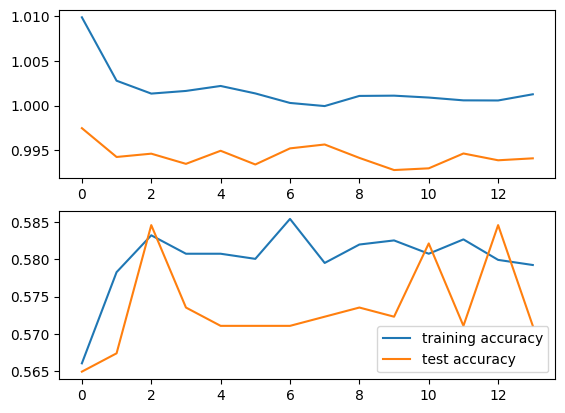

In [314]:
print(datetime.datetime.now())

fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_loss_val, label = 'test loss')
fig2.plot(total_acc_train, label = 'training accuracy')
fig2.plot(total_acc_val, label = 'test accuracy')
plt.legend()
plt.show()

In [315]:
min(total_loss_val), max(total_acc_val)

(0.9928181755776498, 0.5845588235294118)

# Save Model

In [316]:
!mkdir ./saved-models-max/

mkdir: cannot create directory ‘./saved-models-max/’: File exists


In [332]:
PATH = "./saved-models-max/model-epoch{epoch:02d}-loss_val{loss_val:.2f}-acc_val{acc_val:.2f}.pt".format(epoch = epoch, loss_val = total_loss_val[epoch] , acc_val = total_acc_val[epoch])

torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(), # trained parameters
            'optimizer_state_dict': optimizer.state_dict(), # this contains buffers and parameters that are updated as the model trains
            'accuracy':best_val_acc, #'loss': best_val_loss,
            }, PATH)

In [336]:
epoch, total_loss_val[epoch], total_acc_val[epoch]

(3, 0.993508094666051, 0.5735294117647058)

In [329]:
best_model = torch.load(PATH)

In [337]:
WORK_DIR = './'

In [334]:
!ls ./saved-models-max

model-epoch03-loss_val0.99-acc_val0.57.pt
model-epoch04-loss_val0.99-acc_val0.59.pt
model-epoch09-loss_val0.90-acc_val0.63.pt
model-epoch09-loss_val1.00-acc_val0.55.pt
model-epoch24-loss_val1.02-acc_val0.56.pt


In [396]:
DIR = WORK_DIR + 'saved-models-max/'

# weights = os.listdir(DIR)
# weights.sort()
# # val_losses = [filename.split('-')[2].split('val')[1] for filename in weights]
# val_losses = [filename.split('-')[2].split('val')[1] for filename in weights] #[1:]]
# best_weight = val_losses.index(min(val_losses))
# # path = './saved_models/' + weights[best_weight]
# path = DIR + weights[best_weight] #+1] # '.ipynb_checkpoints' 파일이 맨 앞에 있기 때문에 index가 하나씩 밀린다.
path = PATH
path = './saved-models-max/model-epoch04-loss_val0.99-acc_val0.59.pt'

checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
accuracy = checkpoint['accuracy']
# loss = checkpoint['loss']

model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [397]:
path

'./saved-models-max/model-epoch04-loss_val0.99-acc_val0.59.pt'

In [341]:
!ls ./saved-models-max/

model-epoch03-loss_val0.99-acc_val0.57.pt
model-epoch04-loss_val0.99-acc_val0.59.pt
model-epoch09-loss_val0.90-acc_val0.63.pt
model-epoch09-loss_val1.00-acc_val0.55.pt
model-epoch24-loss_val1.02-acc_val0.56.pt


# Evaluate Model

In [342]:
true_labels = []
predicted_labels = []
predicted_values = []

model.eval()
    
test_loss = AverageMeter()
test_acc = AverageMeter()

with torch.no_grad():                                                     # 모델을 평가하는 단계에서는 Gradient를 통해 parameter값이 update되는 현상을 방지하기 위해 'torch.no_grad()' 메서드를 이용해 Gradient의 흐름을 억제
    for image, label in test_loader:
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        output = model(image)
        loss = criterion(output, label)
        prediction = output.max(1, keepdim = True)[1]                     # output값 (prediction probability)가 가장 높은 index(class)로 예측
        
        true_labels.append(label)
        predicted_labels.append(prediction)
        predicted_values.append(output)
        
        test_acc.update(prediction.eq(label.view_as(prediction)).sum().item())
        test_loss.update(loss.item())
        
test_loss.avg, test_acc.avg

(0.9789856074915992, 0.5922222222222222)

In [343]:
len(predicted_values)

900

In [345]:
# tensor to array form
true_test_lst = []
predicted_test_lst = []
predicted_value_lst = []

for i in range(len(test_loader)):
    t_labels = true_labels[i].cpu().numpy()
    true_test_lst += list(t_labels)
    
    p_labels = predicted_labels[i].cpu().numpy()[:,0]
    predicted_test_lst += list(p_labels)
    
    p_values = predicted_values[i].cpu().numpy()
    predicted_value_lst += list(p_values)
    
true_test_arr = np.array(true_test_lst)
predicted_test_arr = np.array(predicted_test_lst)
predicted_value_arr = np.array([list(arr) for arr in predicted_value_lst])
    
true_test_arr[:20], predicted_test_arr[:20], predicted_value_arr[:20]

(array([2, 1, 2, 1, 2, 0, 0, 0, 1, 1, 1, 2, 2, 2, 0, 1, 1, 0, 2, 1]),
 array([2, 0, 2, 1, 0, 1, 2, 1, 0, 2, 1, 2, 2, 2, 1, 1, 0, 0, 2, 2]),
 array([[0.1529137 , 0.3845983 , 0.462488  ],
        [0.59173024, 0.29284275, 0.115427  ],
        [0.14196172, 0.22183213, 0.6362062 ],
        [0.19912198, 0.5557133 , 0.24516475],
        [0.51601887, 0.19955257, 0.28442857],
        [0.21768592, 0.52015907, 0.26215506],
        [0.19317344, 0.30139852, 0.505428  ],
        [0.27451137, 0.6130696 , 0.11241905],
        [0.54991   , 0.22449936, 0.22559065],
        [0.20636012, 0.35317466, 0.4404652 ],
        [0.09888766, 0.73697406, 0.16413827],
        [0.03525178, 0.04052922, 0.924219  ],
        [0.18455505, 0.24270713, 0.5727378 ],
        [0.12191967, 0.12415975, 0.75392056],
        [0.34743935, 0.44295025, 0.20961042],
        [0.1651171 , 0.61288065, 0.22200224],
        [0.70608187, 0.12604536, 0.1678728 ],
        [0.79551584, 0.07741436, 0.12706985],
        [0.08799037, 0.09878728,

In [471]:
DIR = WORK_DIR + 'saved-models-max/'

# weights = os.listdir(DIR)
# weights.sort()
# # val_losses = [filename.split('-')[2].split('val')[1] for filename in weights]
# val_losses = [filename.split('-')[2].split('val')[1] for filename in weights] #[1:]]
# best_weight = val_losses.index(min(val_losses))
# # path = './saved_models/' + weights[best_weight]
# path = DIR + weights[best_weight] #+1] # '.ipynb_checkpoints' 파일이 맨 앞에 있기 때문에 index가 하나씩 밀린다.
path = PATH
path = './saved-models-max/model-epoch24-loss_val1.02-acc_val0.56.pt'

checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
accuracy = checkpoint['accuracy']
# loss = checkpoint['loss']

model.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [472]:
path

'./saved-models-max/model-epoch24-loss_val1.02-acc_val0.56.pt'

In [473]:
!ls ./saved-models-max/

model-epoch03-loss_val0.99-acc_val0.57.pt
model-epoch04-loss_val0.99-acc_val0.59.pt
model-epoch09-loss_val0.90-acc_val0.63.pt
model-epoch09-loss_val1.00-acc_val0.55.pt
model-epoch24-loss_val1.02-acc_val0.56.pt


In [474]:
p_annot_df = p_annot_df_copy

In [475]:
y = p_annot_df.Event_Label[-841:-1]
X = p_annot_df[['ID','Start_Epoch','Case', 'FPS', 'Frames']][-841:-1]

In [476]:
test_dataset = Dataset(X, y, imagetype, labels)
test_loader = DataLoader(test_dataset)

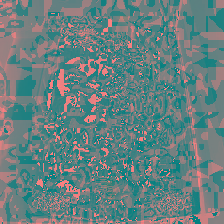

In [477]:
image, label = test_dataset[100]

Image.fromarray(np.transpose(np.array(image).astype('uint8'), (2,1,0)))

In [478]:
true_labels = []
predicted_labels = []
predicted_values = []

model.eval()
    
test_loss = AverageMeter()
test_acc = AverageMeter()

with torch.no_grad():                                                     # 모델을 평가하는 단계에서는 Gradient를 통해 parameter값이 update되는 현상을 방지하기 위해 'torch.no_grad()' 메서드를 이용해 Gradient의 흐름을 억제
    for image, label in tqdm(test_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        output = model(image)
        loss = criterion(output, label)
        prediction = output.max(1, keepdim = True)[1]                     # output값 (prediction probability)가 가장 높은 index(class)로 예측
        
        true_labels.append(label)
        predicted_labels.append(prediction)
        predicted_values.append(output)
        
        test_acc.update(prediction.eq(label.view_as(prediction)).sum().item())
        test_loss.update(loss.item())
        
test_loss.avg, test_acc.avg

  0%|          | 0/840 [00:00<?, ?it/s]/usr/local/lib/python3.8/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
100%|██████████| 840/840 [00:21<00:00, 38.34it/s]


(1.0644425535485857, 0.5261904761904762)

In [479]:
# tensor to array form
true_test_lst = []
predicted_test_lst = []
predicted_value_lst = []

for i in range(len(test_loader)):
    t_labels = true_labels[i].cpu().numpy()
    true_test_lst += list(t_labels)
    
    p_labels = predicted_labels[i].cpu().numpy()[:,0]
    predicted_test_lst += list(p_labels)
    
    p_values = predicted_values[i].cpu().numpy()
    predicted_value_lst += list(p_values)
    
true_test_arr = np.array(true_test_lst)
predicted_test_arr = np.array(predicted_test_lst)
predicted_value_arr = np.array([list(arr) for arr in predicted_value_lst])
    
true_test_arr[:120], predicted_test_arr[:120], predicted_value_arr[:120]

(array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0, 0, 1, 2, 2, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 1, 1, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 1, 2]),
 array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 0, 1, 1, 1, 1, 1]),
 array([[0.18614742, 0.19534007, 0.6185125 ],
        [0.18614742, 0.19534007, 0.6185125 ],
        [0.18614742, 0.19534007, 0.6185125 ],
        [0.18614742, 0.19534007, 0.6185125

In [480]:
np.unique(true_test_arr, return_counts=True)

(array([0, 1, 2]), array([131, 467, 242]))

In [481]:
np.unique(predicted_test_arr, return_counts=True)

(array([0, 1, 2]), array([142, 646,  52]))

In [482]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

In [483]:
sklearn.metrics.f1_score(true_test_arr, predicted_test_arr, average='macro')

0.3960750241073691

In [7]:
import pandas as pd
gt = pd.read_csv('gt.csv')
my = pd.read_csv('submittttt.csv')

In [8]:
true_test_arr = gt['answer'].tolist()
predicted_test_arr = my['answer'].tolist()

In [12]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

sklearn.metrics.f1_score(true_test_arr, predicted_test_arr, average='macro')

0.34216679279627177

In [224]:
# Confusion Matrix
tick_labels = ['Wake', 'Light Sleep','Deep Sleep']

cm = confusion_matrix(true_test_arr, predicted_test_arr)
ax = sns.heatmap(cm, annot=True, fmt="d")
plt.ylabel('Actual')
plt.xlabel('Predicted')
ax.set_xticklabels(tick_labels)
ax.set_yticklabels(tick_labels)

NameError: name 'sns' is not defined

In [ ]:
# Classification Report

labels = ['Wake', 'Light Sleep','Deep Sleep']

print(classification_report(true_test_arr, predicted_test_arr, target_names = labels))

In [ ]:
# roc curve for classes

fpr = {}
tpr = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(true_test_arr == i, predicted_value_arr[:, i])
    
# plotting
plt.plot(fpr[1], tpr[1], linestyle='--',color='blue', label='Positive: Opacity / Negative: Normal') # Sensitivity: 비정상 중에 비정상으로 predict된 비율 / Specificity: 정상 중에 정상으로 predict된 비율
plt.title('ROC curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.legend(loc='best') 